In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))



Aux function for splitting between training and testing


In [7]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def leaves(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def wood(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def pole(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def grape(input, target):
    target = target.squeeze(1)
    mask = target != 4
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=4
        mask[mask==150]=1
        mask[mask==76]=3
        mask[mask==74]=3
        mask[mask==29]=2
        mask[mask==25]=2
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images/'train'
path_manual_lbl = path_labels/'train'

dataset/Images/train/color_159.jpg


<AxesSubplot:>

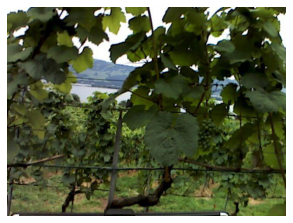

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/train/gt_159.png


<AxesSubplot:>

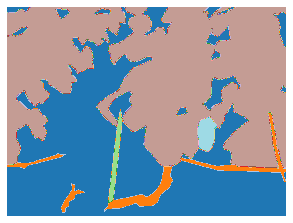

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
np.unique(np.array(mask))

array([  0,  29,  76, 150, 255], dtype=uint8)

In [19]:
bs = 4

In [20]:
codes

array(['Background', 'Leaves', 'Wood', 'Pole', 'Grape'], dtype='<U10')

In [21]:
??get_image_files

In [22]:
def my_get_items(folders,path):
    return (get_image_files(path))

In [23]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','trainSemi','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((640,640)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [24]:
#x,mask=dls.one_batch()

# HRNet

In [25]:
learn = get_segmentation_learner(dls=dls, number_classes=5, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[background,leaves,pole,grape,wood,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


SuggestedLRs(lr_min=0.2290867567062378, lr_steep=1.9054607152938843)

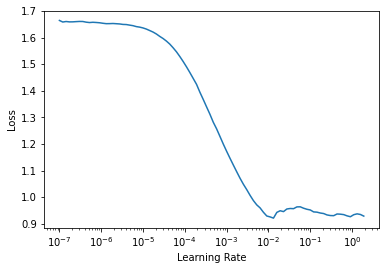

In [26]:
learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,1.019315,1.275680,0.878475,0.481324,0.698771,0.698054,0.699799,0.690828,00:59
1,0.453707,1.001629,0.912479,0.613424,0.774795,0.768367,0.775054,0.768096,00:58
2,0.257814,0.565784,0.859112,0.812273,0.854023,0.851809,0.858461,0.850283,00:58
3,0.197916,0.550516,0.884395,0.777141,0.849335,0.848685,0.855036,0.845644,01:00
4,0.168125,0.482200,0.880569,0.789363,0.856666,0.857167,0.860991,0.852216,01:00
5,0.162739,0.443258,0.887776,0.767707,0.844614,0.847909,0.848667,0.841825,01:01
6,0.146115,0.486395,0.883297,0.798235,0.859839,0.859809,0.865278,0.856341,01:00
7,0.139777,0.392145,0.873629,0.817374,0.861897,0.862952,0.866780,0.859527,01:01
8,0.133170,0.379172,0.877343,0.801358,0.859158,0.861502,0.865488,0.856458,01:01
9,0.132122,0.427050,0.892815,0.776904,0.850069,0.852422,0.855118,0.847667,01:01


Better model found at epoch 0 with valid_loss value: 1.275679588317871.


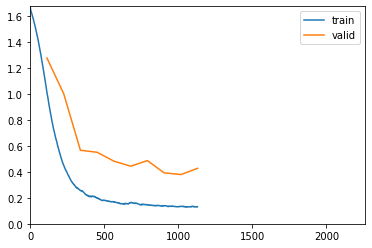

Better model found at epoch 1 with valid_loss value: 1.0016285181045532.
Better model found at epoch 2 with valid_loss value: 0.5657835602760315.
Better model found at epoch 3 with valid_loss value: 0.5505157113075256.
Better model found at epoch 4 with valid_loss value: 0.48219984769821167.
Better model found at epoch 5 with valid_loss value: 0.4432579576969147.
Better model found at epoch 7 with valid_loss value: 0.3921447694301605.
Better model found at epoch 8 with valid_loss value: 0.3791724145412445.
No improvement since epoch 8: early stopping


In [27]:
fname="hrnet-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [28]:
learn.load("hrnet-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,0.128468,0.384029,0.889406,0.785190,0.854357,0.856159,0.860693,0.851935,01:01
1,0.127593,0.384892,0.893252,0.779169,0.852289,0.853873,0.858559,0.849944,01:01
2,0.129122,0.386371,0.894389,0.777560,0.851763,0.853254,0.857998,0.849432,01:01


Better model found at epoch 0 with valid_loss value: 0.384029358625412.


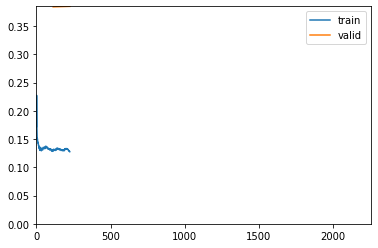

No improvement since epoch 0: early stopping


In [29]:
fname="hrnet-PseudoLabel-Ensemble"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [30]:
learn.validate()

(#7) [0.384029358625412,0.8894062042236328,0.7851896286010742,0.8543573021888733,0.8561590313911438,0.8606930375099182,0.8519346117973328]

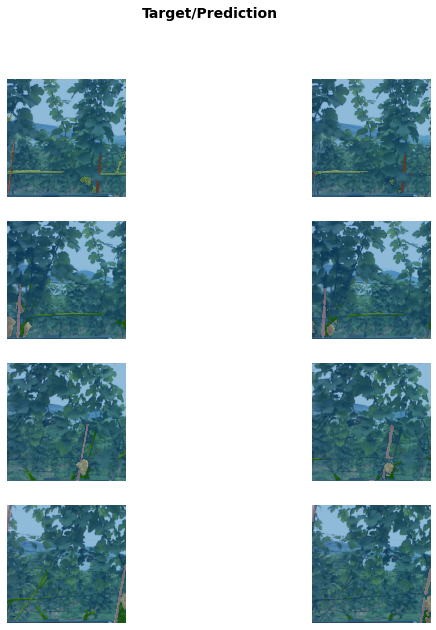

In [31]:
learn.show_results(figsize=(10,10))

In [32]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("hrnet.pth")

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# HRNet

model = torch.jit.load("hrnet.pth")
model = model.cpu()
model.eval()


RecursiveScriptModule(
  original_name=HRNet
  (backbone): RecursiveScriptModule(
    original_name=HighResolutionNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (conv2): RecursiveScriptModule(original_name=Conv2d)
    (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): Recu

In [34]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [35]:
image = Image.open('dataset/Images/test/color_154.jpg')

In [36]:
image = transforms.Resize((480,640))(image)
tensor = transform_image(image=image)

In [37]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

In [38]:
outputs.to

<function Tensor.to>

In [39]:
mask = np.array(outputs.cpu())

In [40]:
mask[mask==4]=255
mask[mask==1]=150
mask[mask==3]=76
mask[mask==2]=29

In [41]:
mask=np.reshape(mask,(480,640))

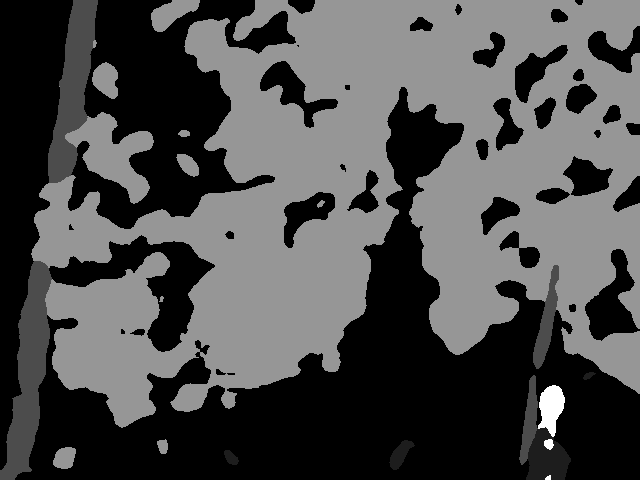

In [42]:
maskShow = Image.fromarray(mask.astype('uint8'))
maskShow

In [43]:
maskrgb = maskShow.convert('RGB')
maskrgb = np.array(maskrgb)
maskrgb[(maskrgb==[150,150,150]).all(axis=2)]=[0,255,0]
maskrgb[(maskrgb==[76,76,76]).all(axis=2)]=[255,0,0]
maskrgb[(maskrgb==[29,29,29]).all(axis=2)]=[0,0,255]

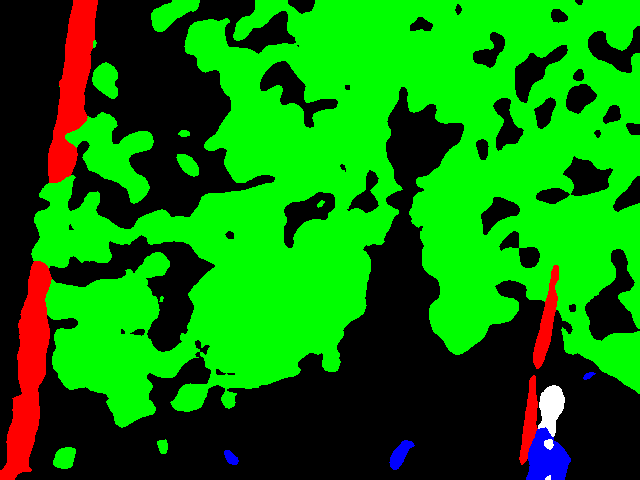

In [44]:
maskRGBShow = Image.fromarray(maskrgb.astype('uint8'))
maskRGBShow

In [45]:
maskRGBShow.save('hrnet_pred_154.jpg')